### mitoproteomics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import copy
import sys
sys.path.append('../py_modules')
import module_shiftedcmap as scmap
import module_clusterheatmap_de as clustermap
import module_denrichr as denrichr
import module_plt_params_de
import module_venn_de as venn
import module_kde_de as kde
from sklearn import preprocessing
import importlib as imp

df = pd.read_table('mitoproteomics_acute_preprocessed.txt')

In [2]:
# correlation matrix
imp.reload(clustermap)
cor_matrix = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')].corr()
samplenames = ['Control 1', 'Control 2', 'Control 3', 'Control 4', 'Control 5', 'EAE 1', 'EAE 2', 'EAE 3', 'EAE 4', 'EAE 5', 'EAE 6']
cor_matrix.columns = samplenames
cor_matrix.index = samplenames
clustermap.clustermap(cor_matrix, linewidth=.25, cbar_label="Pearson \u03C1", fancycmap=False, coldend=False, extrapadding=.05, cmethod='complete', )
[plt.savefig(f'output/mitoproteomics_acut_correlation.{f}', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.05) for f in ['svg', 'pdf', 'png']]
plt.close()

In [3]:
fig = plt.figure(figsize=(1.1,1.1))

# QQ

imp.reload(kde)
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(np.array(df.iloc[:, 1:12]))
df_std = copy.copy(df)
df_std.iloc[: ,1:12] = scaled_df
kde.kde_function(scaled_df.flatten(), ax=[fig.add_axes([0,-1.7,1,1]),fig.add_axes([2,-1.7,1,1])], titles=['C', 'D'])

# roc analysis

def sensitivity(x):
    return(len(df.loc[df.q <= 0.05, :]) / (len(df.loc[df.q <= 0.05, :]) + len(df.loc[(df.q <= 0.05) & (df.log2fc < x), :])))

def specificity(x):
    return(len(df.loc[df.q > 0.05, :]) / (len(df.loc[df.q > 0.05, :]) + len(df.loc[(df.q > 0.05) & (df.log2fc > x), :])))

sens = []
spec = []
tsens = []
tspec = []
dist = []
xvals= np.abs(np.log2(np.linspace(0.01,4,250)))
for x in xvals:
    sens.append(sensitivity(x))
    tsens.append(1-sensitivity(x))
    spec.append(specificity(x))
    tspec.append(1-specificity(x))
    dist.append(np.sqrt(np.sum([np.exp(1-sensitivity(x)), np.exp(1-specificity(x))])))

ax = fig.add_axes([2,-3.4,1,1])
ax.plot(tsens, spec, c='black', lw=1)
ax.set_xlabel('1 - Sensitivity')
ax.set_ylabel('Specificity', color='black')
ax.set_title('F', weight=600, loc='left')

ax = fig.add_axes([0,-5.1,1,1])
ax.plot(xvals, dist, c='k', lw=1)
ax.set_xlabel('FC threshold')
ax.set_ylabel('Distance')
ax.set_xticks(np.round(ax.get_xticks(), 2))
ax.axvline(np.log2(1.5), c = "black", linestyle = "dashed", linewidth = 0.5)
ax.set_title('G', weight=600, loc='left')

# pca

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')]
x = StandardScaler().fit_transform(np.transpose(x)) # Standardizing the features

pca = PCA(n_components = 2)
pcs = pca.fit_transform(x)
pc1var = round(pca.explained_variance_ratio_[0],2) * 100
pc2var = round(pca.explained_variance_ratio_[1],2) * 100
pcadf = pd.DataFrame(data = pcs, columns = ["pc1", "pc2"])
pcadf["sample"] = df.loc[:, df.columns.str.contains('ctrl|eae') & ~df.columns.str.contains('mean')].columns

ax = fig.add_axes([0,-3.4,1,1])

for sample, color in zip(["lfqctrl", "lfqeae"], ['0.8', '0.1']):
    ax.scatter('pc1', 'pc2', data=pcadf.loc[pcadf['sample'].str.contains(sample), :], s=25, edgecolors='k', lw=.25, label=sample, c=color)
ax.set_xlabel("PC1 ("+str(pc1var)+"%)")
ax.set_ylabel("PC2 ("+str(pc2var)+"%)")
ax.set_title('E', weight=600, loc='left')
ax.set_xlim([-60,60])
ax.set_ylim([-40,80])

ax = fig.add_axes([1.1,-3.4,1,1])
ax.scatter([0,0], [-1,1], c=['0.1', '0.8'], s=25, lw=.25, edgecolors='k', clip_on=False)
ax.text(0.1, 1, 'Control', va='center')
ax.text(0.1, -1, 'EAE', va='center')
ax.set_ylim([-8,8])
ax.set_xlim([0,2])
ax.axis('off')

# mito versus non mito abundance
mito = df_std.loc[df_std.mitocarta==1, :].iloc[: ,1:12].mean(axis=1).tolist()
nonmito = df_std.loc[df_std.mitocarta==0, :].iloc[: ,1:12].mean(axis=1).tolist()

ax = fig.add_axes([2,0,.5,1])
plot = ax.violinplot([mito, nonmito], showmeans=True)
ax.set_ylabel('log$_{2}$(expression)\n[z score]')
ax.set_xticks([1,2])
ax.set_xticklabels(['mito', '\u00f8 mito'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['0.1', '0.8']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

ax.scatter(1, np.mean(mito), color='0.8', linewidth=1, zorder=3, marker="_")
ax.vlines(1, np.sqrt(np.var(mito))+np.mean(mito), -np.sqrt(np.var(mito))+np.mean(mito), color='0.8', linestyle='-', lw=.5)
ax.scatter(2, np.mean(nonmito), color='0.1', linewidth=1, zorder=3, marker="_")
ax.vlines(2, np.sqrt(np.var(nonmito))+np.mean(nonmito), -np.sqrt(np.var(nonmito))+np.mean(nonmito), color='0.1', linestyle='-', lw=.5)
ax.axhline(0, color='k', linestyle='--', zorder=-1)
ax.set_title('B', weight=600, loc='left')

ax.set_yticks(np.arange(-2,5))
ax.set_ylim([-2,4])

# venn diagram
ax = fig.add_axes([0,0,1,1])
len_mitocarta, len_dfmito, len_dfnomito = len(pd.read_csv('repos/Mouse.MitoCarta2.0.csv', sep=';')), len(df.loc[df.mitocarta==1,:]), len(df.loc[df.mitocarta==0,:])
venn.venn2(subsets = (len_dfnomito, len_mitocarta, len_dfmito), set_labels = ('This dataset', 'MitoCarta'), set_colors=('0.1', '0.8'), normalize_to=2, alpha = 0.6, ax=ax)
ax.set_title('A', weight=600, loc='left')

# volcano

ax = fig.add_axes([2,-5.1,1,1])

c = ['0.5' if enriched == 1 else '0.1' for enriched in df.enriched]
c = ['0.5' if q <= .05 else '0.1' for q in df.q]
ax.scatter(df.log2fc, -np.log2(df.q), s=3, alpha=.5, c=c, lw=0)
ax.axhline(-np.log2(.05))
ax.axvline(-np.log2(1.5)), ax.axvline(np.log2(1.5))
ax.set_xlabel('log$_{2}$(EAE/control)')
ax.set_ylabel('-log$_{2}$($\it{q}$)')
ax.set_title('H', weight=600, loc='left')

legend_dict = dict(zip(['|FC| < log$_{2}$(1.5) OR $\it{q}$ > 0.05', '|FC| \u2265 log$_{2}$(1.5) AND $\it{q}$ \u2264 0.05'], ['0.1', '0.8']))
y = np.linspace(0,1,12)[[6, 5]]
x = [0]*2
ax = fig.add_axes([3.1,-5.1,.1,1])
ax.scatter(x, y, s=10, c=legend_dict.values(), lw=0)
for i, text in enumerate(legend_dict.keys()):
    ax.text(x[i]+.05,y[i], text, va='center', ha='left', fontsize=6)
ax.set_ylim([0,1])
ax.axis('off')

[plt.savefig(f'output/mitoproteomics_acute_overview.{f}', facecolor='white', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.05) for f in ['svg', 'pdf', 'png']]
plt.close()

In [4]:
# for paper (version 1)
'''
df = pd.read_table("mitoproteomics_acute_preprocessed.txt")
sys.path.append('..\py_modules')
import nezzworker.nezzworker as nezzworker
import imp
imp.reload(nezzworker)

gene_exp = df.loc[df.mitocarta == 1, :].iloc[:, 0:12]

gene_exp = gene_exp.rename(columns={'gene': 'Gene_symbol'})

cls = ['wt', 'wt', 'wt', 'wt', 'wt', 'eae', 'eae', 'eae', 'eae', 'eae', 'eae']
gene_exp.index = range(len(gene_exp))
res = nezzworker.nezzworgs(gene_exp,
                        method='classical',
                        categories=cls,
                        outputname='mitoproteomics_paper', id1='Control', id2='EAE',
                        gsea_cutoff=.25,
                        gsea_cutoff_type='p',
                        edge_cutoff=.75,
                        seed=3, # old seed is 39, new seed is 3, newest is 45
                        expressionlevels=1,
                        geneset='reactome7.1',
                        xy='similarity',
                        invert=True,
                        npermut=500,
                        kfactor_iteration=False,
                        kfactor=3,
                        layout='spring',
                        popup=False,
                        n_extremes=10,
                        vflip=True,
                        hflip=True,
                        rotate=-np.pi/180*45,
                        aspectratio=1).run()
'''

'\ndf = pd.read_table("mitoproteomics_acute_preprocessed.txt")\nsys.path.append(\'..\\py_modules\')\nimport nezzworker.nezzworker as nezzworker\nimport imp\nimp.reload(nezzworker)\n\ngene_exp = df.loc[df.mitocarta == 1, :].iloc[:, 0:12]\n\ngene_exp = gene_exp.rename(columns={\'gene\': \'Gene_symbol\'})\n\ncls = [\'wt\', \'wt\', \'wt\', \'wt\', \'wt\', \'eae\', \'eae\', \'eae\', \'eae\', \'eae\', \'eae\']\ngene_exp.index = range(len(gene_exp))\nres = nezzworker.nezzworgs(gene_exp,\n                        method=\'classical\',\n                        categories=cls,\n                        outputname=\'mitoproteomics_paper\', id1=\'Control\', id2=\'EAE\',\n                        gsea_cutoff=.25,\n                        gsea_cutoff_type=\'p\',\n                        edge_cutoff=.75,\n                        seed=3, # old seed is 39, new seed is 3, newest is 45\n                        expressionlevels=1,\n                        geneset=\'reactome7.1\',\n                        xy=

GSEA started.
almost done
GSEA done.
45 gene sets found.
29 gene sets remaining after p/q value filtering.
29 gene sets remaining after NES filtering.


../py_modules/nezzworker/nezzworker.py:476: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  exprlevels = [self.input_data.loc[self.input_data.Gene_symbol.isin(gsea_res.genes[i].split(';')), :].mean().mean() for i in range(len(gsea_res))]


Adjacency matrix computed.
Network (spring) computed.
Script done.
---


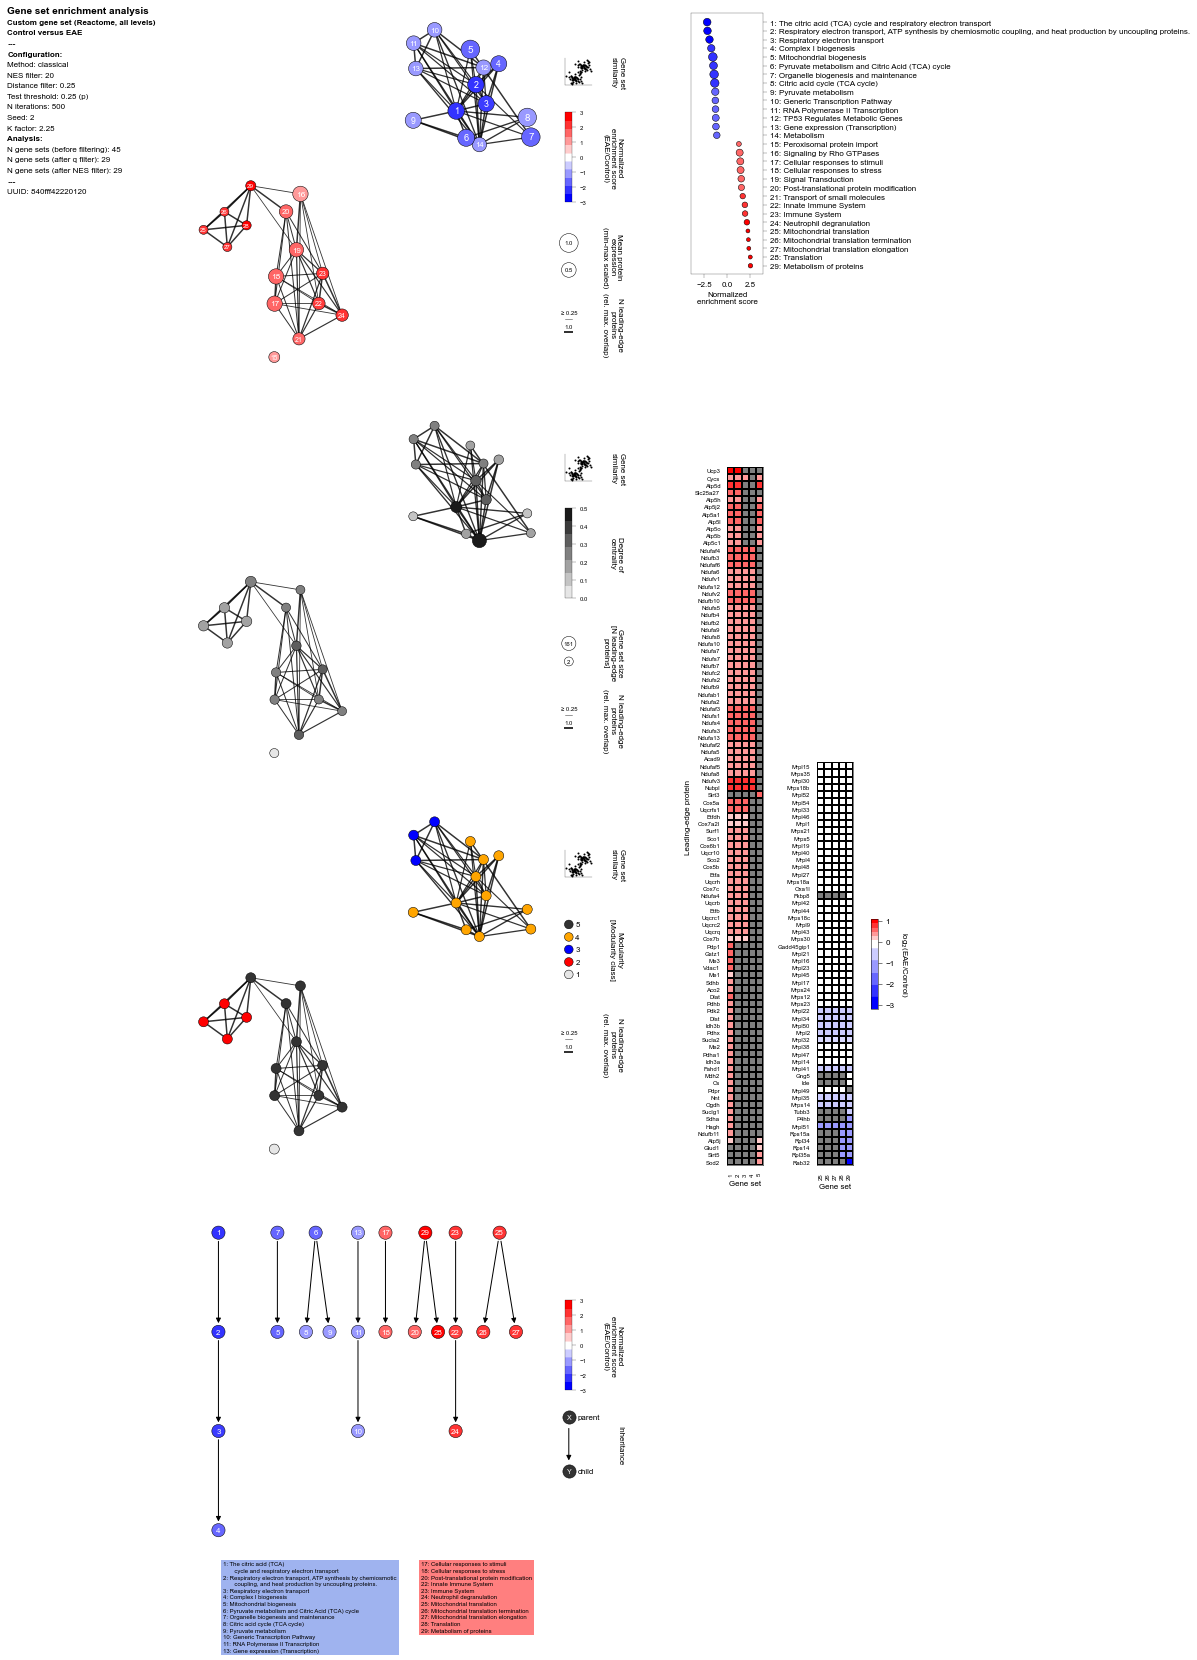

In [18]:
# for paper (version 2)
df = pd.read_table("mitoproteomics_acute_preprocessed.txt")
sys.path.append('..\py_modules')
import nezzworker.nezzworker as nezzworker
import imp
imp.reload(nezzworker)

gene_exp = df.loc[df.mitocarta == 1, :].iloc[:, 0:12]

gene_exp = gene_exp.rename(columns={'gene': 'Gene_symbol'})

cls = ['wt', 'wt', 'wt', 'wt', 'wt', 'eae', 'eae', 'eae', 'eae', 'eae', 'eae']
gene_exp.index = range(len(gene_exp))

res = nezzworker.nezzworgs(gene_exp,
                           method='classical',
                           categories=cls,
                           outputname='mitoproteomics_paper_v2', id1='Control', id2='EAE',
                           gsea_cutoff=.25,
                           seed=2,
                           expressionlevels=1,
                           geneset='custom_all',
                           xy='similarity',
                           invert=True,
                           npermut=500,
                           layout='spring',
                           popup=False,
                           fileformat='all',
                           n_extremes=20).run()

GSEA started.
almost done
GSEA done.
45 gene sets found.
28 gene sets remaining after p/q value filtering.
28 gene sets remaining after NES filtering.
Adjacency matrix computed.
Network (spring) computed.
Script done.
---


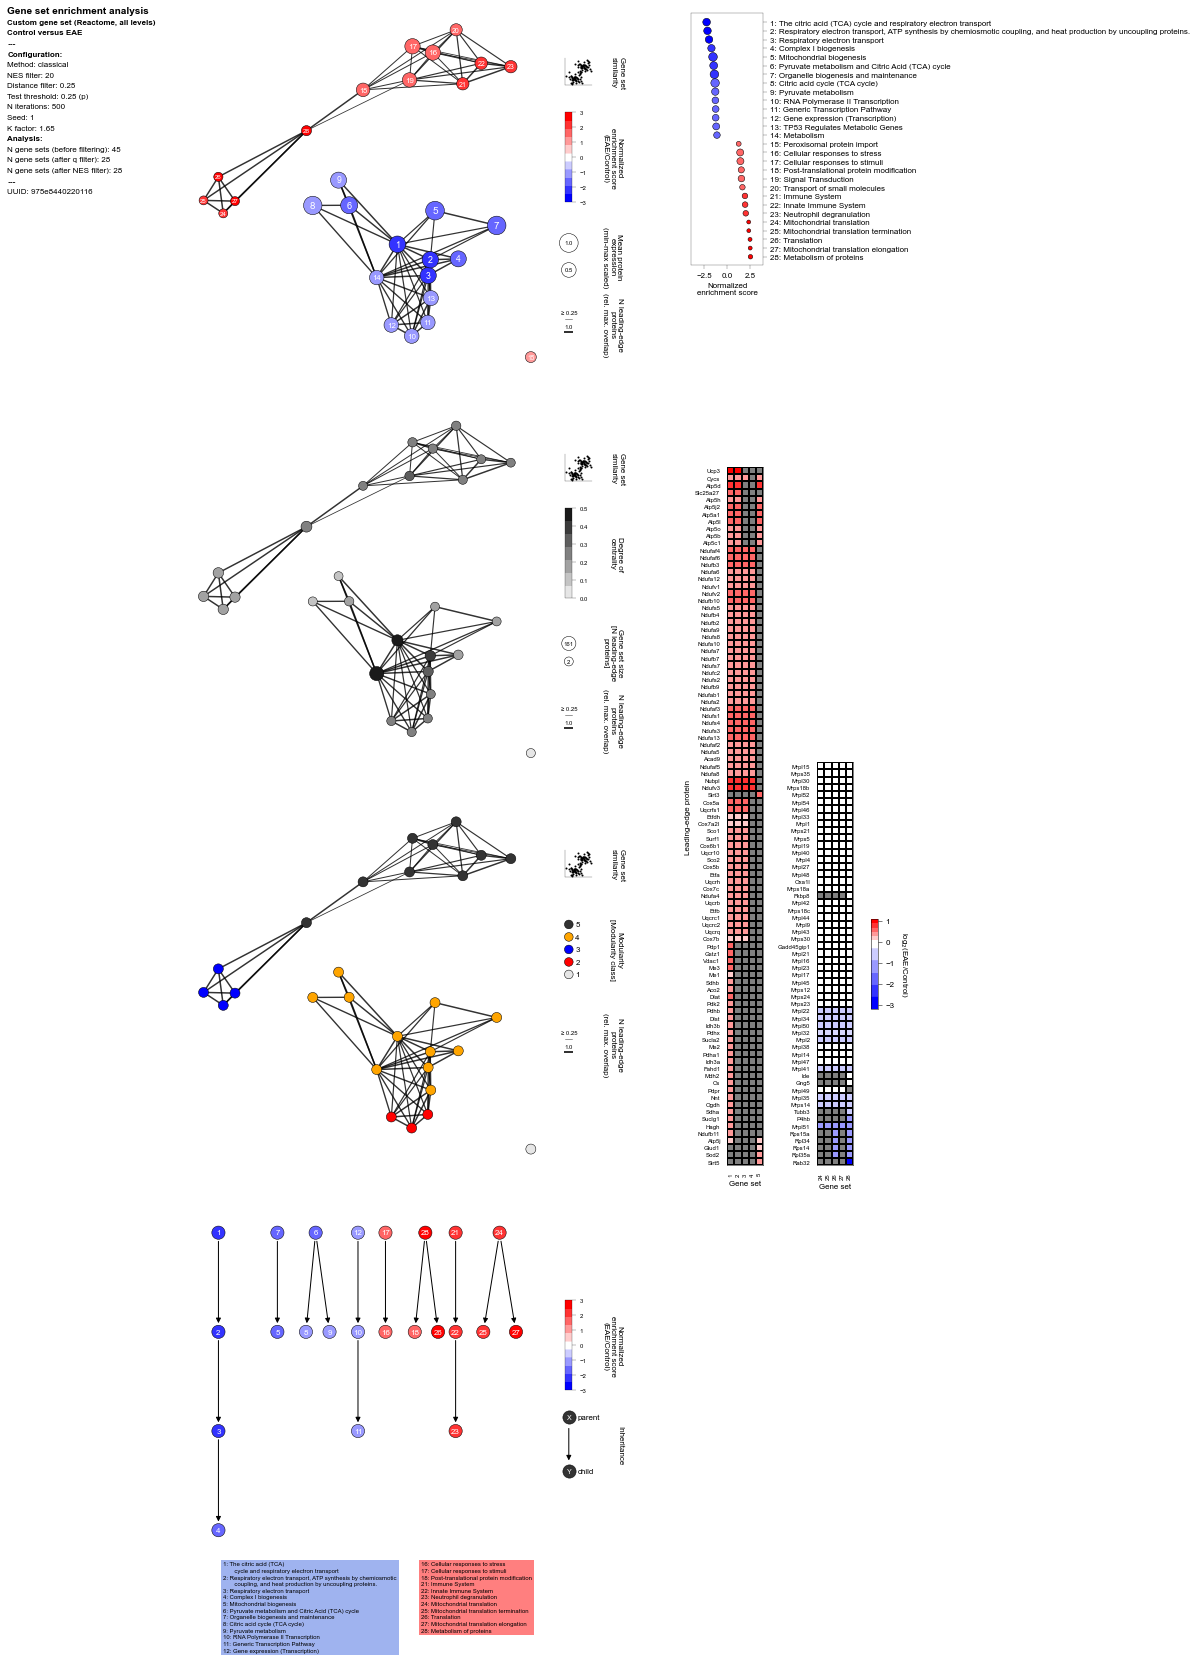

In [6]:
# for phd thesis
df = pd.read_table("mitoproteomics_acute_preprocessed.txt")
sys.path.append('..\py_modules')
import nezzworker.nezzworker as nezzworker
import imp
imp.reload(nezzworker)

gene_exp = df.loc[df.mitocarta == 1, :].iloc[:, 0:12]

gene_exp = gene_exp.rename(columns={'gene': 'Gene_symbol'})

cls = ['wt', 'wt', 'wt', 'wt', 'wt', 'eae', 'eae', 'eae', 'eae', 'eae', 'eae']
gene_exp.index = range(len(gene_exp))

res = nezzworker.nezzworgs(gene_exp,
                           method='classical',
                           categories=cls,
                           outputname='mitoproteomics_phd', id1='Control', id2='EAE',
                           gsea_cutoff=.25,
                           seed=1,
                           expressionlevels=1,
                           geneset='custom_all',
                           xy='similarity',
                           invert=True,
                           npermut=500,
                           layout='spring',
                           popup=False,
                           fileformat='all',
                           n_extremes=20).run()

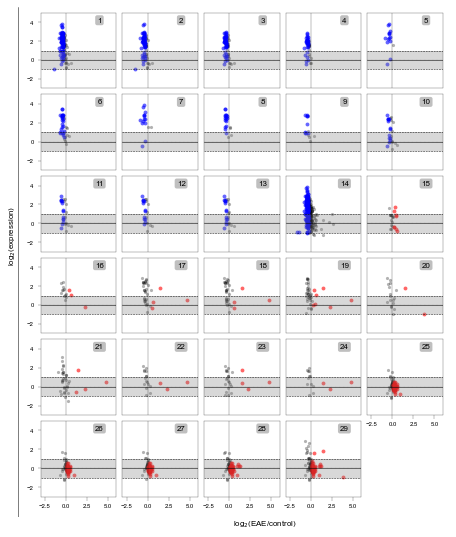

In [19]:
fig = plt.figure(figsize=(1.05,1.05))

from sklearn.preprocessing import scale
import module_plt_params_de

rowpos = 0
colpos = 0
for i, gs in zip(range(len(res.gsea_res)), res.gsea_res.index[::-1]):

    df['meanexpr'] = scale(df[['mean_log2lfqctrl', 'mean_log2lfqeae']].mean(axis=1))
    all_genes = [gene.capitalize() for gene in res.gsea_res.loc[gs, :]['genes'].split(';')]
    ledge_genes = [gene.capitalize() for gene in res.gsea_res.loc[gs, :]['ledge_genes'].split(';')]
    
    rowpos_old, colpos_old = rowpos, colpos
    rowpos = rowpos if i not in [x for x in range(len(res.gsea_res))][::5] else rowpos+1
    colpos = colpos+1 if i not in [x for x in range(len(res.gsea_res))][::5] else 0
    ax = fig.add_axes([colpos+colpos*0.08,-rowpos-rowpos*0.08, 1,1])
    ax.scatter('log2fc', 'meanexpr', data=df.loc[(df.gene.isin(all_genes)) & ~(df.gene.isin(ledge_genes)), :], s=10, linewidth=0, alpha=.3, c='black')
    ax.scatter('log2fc', 'meanexpr', data=df.loc[((df.gene.isin(ledge_genes)) & (df.log2fc<0)), :], s=15, linewidth=0, alpha=.6, c='blue')
    ax.scatter('log2fc', 'meanexpr', data=df.loc[((df.gene.isin(ledge_genes)) & (df.log2fc>0)), :], s=15, linewidth=0, alpha=.6, c='red')
    ax.axhspan(-1, 1, facecolor='grey' ,alpha=.3, lw=0)
    ax.axvline(0, c='k', lw=.25)
    ax.axhline(df['meanexpr'].mean(), ls='dashed', c='black', alpha=.5, lw=.25)
    ax.axhline(0, c='k')
    ax.axhline(1, ls='dashed')
    ax.axhline(-1, ls='dashed')
    #ax.set_xlabel('log$_2$(EAE/control)')
    #ax.set_ylabel('log$_2$(expression)')
    ax.text(4, 4, str(i+1), fontsize=8, bbox={'facecolor':'grey', 'alpha':0.5, 'pad':.25, 'linewidth':0, 'boxstyle':'round'}, ha='center')
   
    if rowpos_old == rowpos:
        ax.set_yticks([])
        ax.set_ylabel(None)
    else:
        pass
    
for ax in fig.axes:
    if ax in [ax for ax in fig.axes][-5:]:
        pass
    else:
        ax.set_xticks([])
        ax.set_xlabel('')
    
xlims = np.array([ax.get_xlim() for ax in fig.axes])[:, 0].min().round()-1, np.array([ax.get_xlim() for ax in fig.axes])[:, 1].max().round()+1
ylims = np.array([ax.get_ylim() for ax in fig.axes])[:, 0].min().round()-1, np.array([ax.get_ylim() for ax in fig.axes])[:, 1].max().round()+1

[ax.set_xlim(xlims) for ax in fig.axes]
[ax.set_ylim(ylims) for ax in fig.axes]

ax = fig.add_axes([-0.3, -rowpos-.5-.25, 5.7, rowpos+.5+.25])
ax.axis('off')
ax.axhline(0, lw=.5)
ax.axvline(0, lw=.5)
ax.text(0.5, -0.025, 'log$_2$(EAE/control)', va='bottom')
ax.text(-0.025, 0.5, 'log$_2$(expression)', rotation=90)

plt.show()

[fig.savefig(f'output/mitoproteomics_acute_gsea_fcabundance.{f}', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.05) for f in ['svg', 'pdf', 'png']]
plt.close()

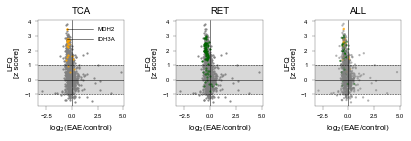

In [21]:
proteins = {'tca':[x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Citric acid cycle (TCA cycle)'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()],
            'ret':[x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Respiratory electron transport'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()],
            'all':df.loc[df.mitocarta==1, 'gene'].tolist()}

fig = plt.figure(figsize=(1.2,1.2))

for i, cohort in enumerate(proteins.keys()):
    
    ax = fig.add_axes([i+i*.6,0,1,1])
    ax.axhspan(-1, 1, facecolor='grey' ,alpha=.3, lw=0)
    ax.axhline(0)
    ax.axvline(0)
    ax.axhline(1, ls='dashed')
    ax.axhline(-1, ls='dashed')
    if cohort != 'all':
        x = df.loc[df.gene.isin([x for x in proteins['all'] if x not in proteins[str(cohort)]]), 'log2fc'].values.tolist()
        y = df.loc[df.gene.isin([x for x in proteins['all'] if x not in proteins[str(cohort)]]), 'meanexpr'].values.tolist()
        ax.scatter(x, y, s=5, alpha=.9, c='.5', lw=0)
        x = df.loc[df.gene.isin([x for x in proteins['all'] if x in proteins[str(cohort)]]), 'log2fc'].values.tolist()
        y = df.loc[df.gene.isin([x for x in proteins['all'] if x in proteins[str(cohort)]]), 'meanexpr'].values.tolist()
        if cohort == 'tca':
            idh3a_expr = df.loc[df.gene=='Idh3a', 'meanexpr'].values[0]
            idh3a_fc = df.loc[df.gene=='Idh3a', 'log2fc'].values[0]
            mdh2_expr = df.loc[df.gene=='Mdh2', 'meanexpr'].values[0]
            mdh2_fc = df.loc[df.gene=='Mdh2', 'log2fc'].values[0]
            ax.scatter(x, y, s=5, alpha=.9, c='orange', lw=0)
            ax.text(idh3a_fc+3, idh3a_expr, 'IDH3A', ha='left', va='center', fontsize=6)
            ax.plot([idh3a_fc, idh3a_fc+2.5], [idh3a_expr, idh3a_expr], lw=.5, c='0')
            ax.text(mdh2_fc+3, mdh2_expr, 'MDH2', ha='left', va='center', fontsize=6)
            ax.plot([mdh2_fc, mdh2_fc+2.5], [mdh2_expr, mdh2_expr], lw=.5, c='0')
        elif cohort == 'ret':
            ax.scatter(x, y, s=5, alpha=.9, c='darkgreen', lw=0)
    else:
        df['sorter'] = [1 if x in proteins['all'] else 0 for x in df.gene.tolist()]
        df = df.sort_values(by='sorter', ascending=True)
        x = df.loc[df.gene.isin([x for x in proteins['all']]), 'log2fc'].values.tolist()
        y = df.loc[df.gene.isin([x for x in proteins['all']]), 'meanexpr'].values.tolist()
        c = ['orange' if x in proteins['tca'] else 'darkgreen' if x in proteins['ret'] else '.5' for x in df.loc[df.gene.isin([x for x in proteins['all']]), 'gene'].values.tolist()]
        ax.scatter(x, y, s=5, alpha=.6, c=c, lw=0)
    ax.set_xlabel('log$_{2}$(EAE/control)')
    ax.set_ylabel('LFQ\n[z score]')
    ax.set_title(str(cohort).upper())

fig.savefig('output/mitoproteomics_tca_ret_lfq_fc.pdf', transparent=True, dpi = 900, bbox_inches="tight")

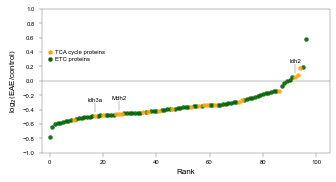

In [9]:
imp.reload(nezzworker)
kegg = nezzworker.getgenesets('kegg').run()

tca_genes = [x.capitalize() for x in kegg['KEGG_CITRATE_CYCLE_TCA_CYCLE']]
tca_genes = [x.capitalize() for x in nezzworker.getgenesets('reactome7.1').run()['REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
tca_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Citric acid cycle (TCA cycle)'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
ret_genes = [x.capitalize() for x in kegg['KEGG_OXIDATIVE_PHOSPHORYLATION']]
ret_genes = [x.capitalize() for x in nezzworker.getgenesets('reactome7.1').run()['REACTOME_RESPIRATORY_ELECTRON_TRANSPORT'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
ret_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Respiratory electron transport'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]

tca_ret = df.sort_values(by='log2fc').loc[df.gene.isin(tca_genes+ret_genes)]
tca_ret['rank'] = range(len(tca_ret))

fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])

ax.axhline(0, lw=.25, zorder=-1)
ax.scatter('rank','log2fc', data=tca_ret.loc[tca_ret.gene.isin(ret_genes)], s=20, lw=0, alpha=.9, color='darkgreen')
ax.scatter('rank','log2fc', data=tca_ret.loc[tca_ret.gene.isin(tca_genes)], s=20, lw=0, alpha=.9, color='orange')

ax.set_xlabel('Rank')
ax.set_ylabel('log$_{2}$(EAE/control)')

ax.text(tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc']+.2, 'Idh3a', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Idh3a']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.text(tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc']+.2, 'Mdh2', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Mdh2']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.text(tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'], tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc']+.2, 'Idh2', ha='center', fontsize=6)
ax.plot([tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'].values[0], tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'rank'].values[0]],
        [tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc'].values[0]+.06, tca_ret.loc[tca_ret.gene.isin(['Idh2']), 'log2fc'].values[0]+.18],
        lw=.25, c='0'
        )

ax.scatter(0, 0.4, s=20, lw=0, color='orange')
ax.text(2, 0.4, 'TCA cycle proteins', ha='left', va='center', fontsize=6)
ax.scatter(0, 0.3, s=20, lw=0, color='darkgreen')
ax.text(2, 0.3, 'ETC proteins', ha='left', va='center', fontsize=6)
ax.set_xlim([-3,105])
ax.set_ylim([-1,1])
ax.set_yticks(np.arange(-1, 1.2,.2))

fig.savefig('output/mitoproteomics_tca_ret_ranks_acute.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)

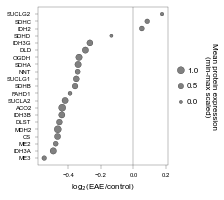

In [22]:
# tca proteins expression
genes = proteins['tca']
fc = df.loc[df.gene.isin(genes), :].sort_values(by='log2fc')['log2fc'].tolist()
exp = df.loc[df.gene.isin(genes), :].sort_values(by='log2fc')['meanexpr'].tolist()
genes = df.loc[df.gene.isin(genes), :].sort_values(by='log2fc')['gene'].tolist()
exp = [((x-np.min(exp))/(np.max(exp)-np.min(exp))*40)+10 for x in exp]

fig = plt.figure(figsize=(1.8,2.2))
ax = fig.add_axes([0,0,1,1])
ax.scatter(fc, [x.upper() for x in genes], s=exp, c='.5', lw=.25, ec='0')
ax.axvline(0, lw=.25)
ax.set_xlabel('log$_2$(EAE/control)')

ax = fig.add_axes([1.05,0,.1,1])
ax.set_ylim([-1,1])
ax.scatter([0,0,0], [-0.2,0,0.2], s=[10, 30, 50], c='.5', lw=.25, ec='0')
for txt, pos in zip(['0.0', '0.5', '1.0'], [-0.2,0,0.2]):
    ax.text(0.05, pos, txt, va='center')
ax.text(0.25, 0, 'Mean protein expression\n(min-max scaled)', rotation=-90, va='center', ha='center')
ax.axis('off')
fig.savefig('output/mitoproteomics_acute_tca_proteins.svg', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=0.01)

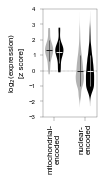

In [61]:
# nuclear-encoded (ne) versus mitochondria-encoded (me) proteins
me_genes = ['Mtnd', 'Mtcytb', 'Mtco', 'Mtatp6', 'Mtatp8']
me_eae = df_std.loc[df_std.gene.str.contains('|'.join(me_genes)), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
ne_eae = df_std.loc[~df_std.gene.str.contains('|'.join(me_genes)), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
me_ctrl = df_std.loc[df_std.gene.str.contains('|'.join(me_genes)), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()
ne_ctrl = df_std.loc[~df_std.gene.str.contains('|'.join(me_genes)), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()

df['genorig'] = ['nuclear' if gene in df.loc[df.mitocarta==1, 'gene'].tolist() and gene not in me_genes else
                 'mito' if gene in me_genes else
                 'None' for gene in df.gene.tolist()]

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,.5,1])
plot = ax.violinplot([me_ctrl, me_eae, ne_ctrl, ne_eae], showmeans=True, positions=[1,2,4,5], widths=.8)

ax.set_ylabel('log$_{2}$(expression)\n[z score]')
ax.set_xticks([1.5,4.5])
ax.set_xticklabels(['mitochondrial-\nencoded', 'nuclear-\nencoded'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['.7', '0', '.7', '0']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

for x,i,c in zip([me_ctrl, me_eae, ne_ctrl, ne_eae],[1,2,4,5],['.1','.9','.1','.9']):
    ax.scatter(i, np.mean(x), color=c, linewidth=1, zorder=3, marker="_")
    ax.vlines(i, np.sqrt(np.var(x))+np.mean(x), -np.sqrt(np.var(x))+np.mean(x), color=c, linestyle='-', lw=.5)

ax.axhline(0, color='k', linestyle='--', zorder=-1, lw=.25)

ax.set_yticks(np.arange(-3,5))
ax.set_ylim([-3,4])

fig.savefig('output/mitoproteomics_mevsne.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)


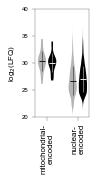

In [60]:
# nuclear-encoded (ne) versus mitochondria-encoded (me) proteins
me_genes = ['Mtnd', 'Mtcytb', 'Mtco', 'Mtatp6', 'Mtatp8']
me_eae = df.loc[df.gene.str.contains('|'.join(me_genes)), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
ne_eae = df.loc[~df.gene.str.contains('|'.join(me_genes)), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
me_ctrl = df.loc[df.gene.str.contains('|'.join(me_genes)), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()
ne_ctrl = df.loc[~df.gene.str.contains('|'.join(me_genes)), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()

df['genorig'] = ['nuclear' if gene in df.loc[df.mitocarta==1, 'gene'].tolist() and gene not in me_genes else
                 'mito' if gene in me_genes else
                 'None' for gene in df.gene.tolist()]

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,.5,1])
plot = ax.violinplot([me_ctrl, me_eae, ne_ctrl, ne_eae], showmeans=True, positions=[1,2,4,5], widths=.8)

ax.set_ylabel('log$_{2}$(LFQ)')
ax.set_xticks([1.5,4.5])
ax.set_xticklabels(['mitochondrial-\nencoded', 'nuclear-\nencoded'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['.7', '0', '.7', '0']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

for x,i,c in zip([me_ctrl, me_eae, ne_ctrl, ne_eae],[1,2,4,5],['.1','.9','.1','.9']):
    ax.scatter(i, np.mean(x), color=c, linewidth=1, zorder=3, marker="_")
    ax.vlines(i, np.sqrt(np.var(x))+np.mean(x), -np.sqrt(np.var(x))+np.mean(x), color=c, linestyle='-', lw=.5)

ax.axhline(0, color='k', linestyle='--', zorder=-1, lw=.25)

ax.set_yticks(np.arange(20,45,5))
ax.set_ylim([20,40])

fig.savefig('output/mitoproteomics_mevsne_raw.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)


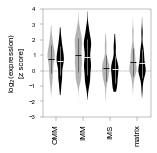

In [62]:
# compartments
mc3 = pd.read_excel('../repos/mitocarta3mouse.xls', sheet_name='A Mouse MitoCarta3.0')
comp = dict(zip(mc3.Symbol.tolist(), mc3['MitoCarta3.0_SubMitoLocalization'].tolist()))
df['comp'] = [comp[gene] if gene in list(comp.keys()) else 'None' for gene in df.gene.tolist()]

df.loc[df.gene.isin(tca_genes)].sort_values(by='log2fc').to_csv('tca_subset.tsv', sep='\t')

mom_eae = df_std.loc[df_std.gene.isin(df.loc[df.comp=='MOM', 'gene'].tolist()), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
mim_eae = df_std.loc[df_std.gene.isin(df.loc[df.comp=='MIM', 'gene'].tolist()), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
ims_eae = df_std.loc[df_std.gene.isin(df.loc[df.comp=='IMS', 'gene'].tolist()), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
matrix_eae = df_std.loc[df_std.gene.isin(df.loc[df.comp=='Matrix', 'gene'].tolist()), df_std.columns.str.contains('^lfqeae')].values.flatten().tolist()
mom_ctrl = df_std.loc[df_std.gene.isin(df.loc[df.comp=='MOM', 'gene'].tolist()), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()
mim_ctrl = df_std.loc[df_std.gene.isin(df.loc[df.comp=='MIM', 'gene'].tolist()), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()
ims_ctrl = df_std.loc[df_std.gene.isin(df.loc[df.comp=='IMS', 'gene'].tolist()), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()
matrix_ctrl = df_std.loc[df_std.gene.isin(df.loc[df.comp=='Matrix', 'gene'].tolist()), df_std.columns.str.contains('^lfqctrl')].values.flatten().tolist()

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,1,1])
plot = ax.violinplot([mom_ctrl, mom_eae, mim_ctrl, mim_eae, ims_ctrl, ims_eae, matrix_ctrl, matrix_eae], showmeans=True, widths=.8, positions=[1,2,4,5,7,8,10,11])

ax.set_ylabel('log$_{2}$(expression)\n[z score]')
ax.set_xticks([1.5,4.5,7.5,10.5])
ax.set_xticklabels(['OMM', 'IMM', 'IMS', 'matrix'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['.7', '0', '.7', '0', '.7', '0', '.7', '0']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

for x,i,c in zip([mom_ctrl, mom_eae, mim_ctrl, mim_eae, ims_ctrl, ims_eae, matrix_ctrl, matrix_eae],[1,2,4,5,7,8,10,11],['.1','.9', '.1', '.9','.1','.9', '.1', '.9']):
    ax.scatter(i, np.mean(x), color=c, linewidth=1, zorder=3, marker="_")
    ax.vlines(i, np.sqrt(np.var(x))+np.mean(x), -np.sqrt(np.var(x))+np.mean(x), color=c, linestyle='-', lw=.5)

ax.axhline(0, color='k', linestyle='--', zorder=-1, lw=.25)

ax.set_yticks(np.arange(-3,5))
ax.set_ylim([-3,4])

fig.savefig('output/mitoproteomics_subcellloc.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)


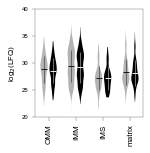

In [57]:
# compartments
mc3 = pd.read_excel('../repos/mitocarta3mouse.xls', sheet_name='A Mouse MitoCarta3.0')
comp = dict(zip(mc3.Symbol.tolist(), mc3['MitoCarta3.0_SubMitoLocalization'].tolist()))
df['comp'] = [comp[gene] if gene in list(comp.keys()) else 'None' for gene in df.gene.tolist()]

df.loc[df.gene.isin(tca_genes)].sort_values(by='log2fc').to_csv('tca_subset.tsv', sep='\t')

mom_eae = df.loc[df.gene.isin(df.loc[df.comp=='MOM', 'gene'].tolist()), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
mim_eae = df.loc[df.gene.isin(df.loc[df.comp=='MIM', 'gene'].tolist()), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
ims_eae = df.loc[df.gene.isin(df.loc[df.comp=='IMS', 'gene'].tolist()), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
matrix_eae = df.loc[df.gene.isin(df.loc[df.comp=='Matrix', 'gene'].tolist()), df.columns.str.contains('^lfqeae')].values.flatten().tolist()
mom_ctrl = df.loc[df.gene.isin(df.loc[df.comp=='MOM', 'gene'].tolist()), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()
mim_ctrl = df.loc[df.gene.isin(df.loc[df.comp=='MIM', 'gene'].tolist()), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()
ims_ctrl = df.loc[df.gene.isin(df.loc[df.comp=='IMS', 'gene'].tolist()), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()
matrix_ctrl = df.loc[df.gene.isin(df.loc[df.comp=='Matrix', 'gene'].tolist()), df.columns.str.contains('^lfqctrl')].values.flatten().tolist()

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,1,1])
plot = ax.violinplot([mom_ctrl, mom_eae, mim_ctrl, mim_eae, ims_ctrl, ims_eae, matrix_ctrl, matrix_eae], showmeans=True, widths=.8, positions=[1,2,4,5,7,8,10,11])

ax.set_ylabel('log$_{2}$(LFQ)')
ax.set_xticks([1.5,4.5,7.5,10.5])
ax.set_xticklabels(['OMM', 'IMM', 'IMS', 'matrix'], rotation=90, ha= 'center', va='top', fontsize=8)
for pc, color in zip(plot['bodies'], ['.7', '0', '.7', '0', '.7', '0', '.7', '0']):
    pc.set_facecolor(color)
    pc.set_edgecolor('None')
    pc.set_alpha(1)
    pc.set_linewidths(.5)
plot['cbars'].set_linewidth(0)
plot['cmaxes'].set_linewidth(0)
plot['cmins'].set_linewidth(0)
plot['cmeans'].set_linewidth(0)

for x,i,c in zip([mom_ctrl, mom_eae, mim_ctrl, mim_eae, ims_ctrl, ims_eae, matrix_ctrl, matrix_eae],[1,2,4,5,7,8,10,11],['.1','.9', '.1', '.9','.1','.9', '.1', '.9']):
    ax.scatter(i, np.mean(x), color=c, linewidth=1, zorder=3, marker="_")
    ax.vlines(i, np.sqrt(np.var(x))+np.mean(x), -np.sqrt(np.var(x))+np.mean(x), color=c, linestyle='-', lw=.5)

ax.axhline(0, color='k', linestyle='--', zorder=-1, lw=.25)

ax.set_yticks(np.arange(20,45,5))
ax.set_ylim([20,40])

fig.savefig('output/mitoproteomics_subcellloc_raw.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)


In [70]:
import scipy.stats as stats
print(f'mito EAE vs control: {stats.ttest_ind(me_eae, me_ctrl)}')
print(f'non-mito EAE vs control: {stats.ttest_ind(ne_eae, ne_ctrl)}')
print(f'MOM EAE vs control: {stats.ttest_ind(mom_eae, mom_ctrl)}')
print(f'MIM EAE vs control: {stats.ttest_ind(mim_eae, mim_ctrl)}')
print(f'IMS EAE vs control: {stats.ttest_ind(ims_eae, ims_ctrl)}')
print(f'Matrix EAE vs control: {stats.ttest_ind(matrix_eae, matrix_ctrl)}')

mito EAE vs control: Ttest_indResult(statistic=-0.5359897823520411, pvalue=0.5933492225050163)
non-mito EAE vs control: Ttest_indResult(statistic=0.01883050459385942, pvalue=0.9849764210016884)
MOM EAE vs control: Ttest_indResult(statistic=-1.78375548391641, pvalue=0.07486981356546567)
MIM EAE vs control: Ttest_indResult(statistic=-3.2195759411460974, pvalue=0.0012988817197209204)
IMS EAE vs control: Ttest_indResult(statistic=-1.1217589019087804, pvalue=0.262813950390611)
Matrix EAE vs control: Ttest_indResult(statistic=-3.8600262513016506, pvalue=0.00011522469367353256)


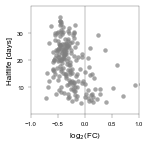

In [13]:
hl = pd.read_csv('./repos/protein_halflives.txt', sep='\t')
df['hl'] = [hl.loc[hl.gene==x, 'halflife_days'].values[0] if x in hl.gene.tolist() else np.nan for x in df.gene]

fig = plt.figure(figsize=(1.5,1.5))
ax = fig.add_axes([0,0,1,1])
ax.axvline(0, lw=.25, zorder=-1)
ax.scatter('log2fc', 'hl', data=df.loc[df.mitocarta==1, :], c='.5', alpha=.7, s=20, lw=0)
ax.set_xlim([-1,1])
ax.set_ylim([0, 40])
ax.set_xticks(np.arange(-1, 1.2,.5))
ax.set_yticks(np.arange(10, 40,10))
ax.set_ylabel('Halflife [days]')
ax.set_xlabel('log$_{2}$(FC)')

fig.savefig('output/mitoproteomics_hl_acute.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)